## 粘度预测模型（Viscosity Prediction）

本代码实现了一个**基于离子对 SMILES 结构的离子液体粘度预测模型**，整体设计严格参考论文  
**《Predicting Ionic Liquid Materials Properties from Chemical Structure》**，用于复现实验并支持后续迁移学习。

---

### 一、模型整体思路

模型以**阳离子 / 阴离子的分子图结构**为输入，使用 **Message Passing Neural Network (MPNN)** 分别对两种离子进行编码，再将其特征进行融合，最终在**物理约束条件下**预测粘度的对数值。

---

### 二、核心结构

- **输入**
  - 阳离子与阴离子的：
    - 原子类别（atom ids）
    - 键类型（bond ids）
    - 图连接关系（edge indices）
  - 温度 `T`（显式作为模型输入）

- **分子编码（MPNN）**
  - 原子 / 键嵌入（Embedding）
  - 多步消息传递（BondMatrixMessage + GatedUpdate）
  - 全局池化（GlobalSumPool）得到分子指纹

- **离子对融合**
  - 对阳离子与阴离子指纹进行逐元素相加（paper-consistent）
  - 经全连接层生成粘度物理参数

---

### 三、物理约束粘度头

模型并非直接回归粘度，而是学习物理参数：

\[
\log(\eta) = A + \frac{B}{T + C}
\]

其中：
- \(A\)：无约束偏置项  
- \(B\)：通过 `softplus + clip` 约束为正值  
- \(C\)：保证温度平移项为合理正区间  
- 温度 \(T\) 进行物理尺度归一化  

该设计确保预测结果**符合实际物理规律**。

---

### 四、训练与评估

- **数据划分**
  - 默认采用论文中的随机划分（存在 pair-level leakage）
  - 代码中预留了 **严格无泄漏划分（按离子对）** 的可选方案

- **训练设置**
  - Optimizer：Adam（带梯度裁剪）
  - Loss：MSE
  - Early Stopping 防止过拟合
  - 自定义 Callback 控制关键 epoch 输出

- **评估指标**
  - R²（决定系数）
  - MAE（平均绝对误差）

---

### 五、结果可视化与保存

- 绘制训练 / 验证损失曲线
- 生成论文对应的 **Figure 2(a)**：实验值 vs 预测值散点图
- 保存最终模型为 `.keras` 格式，用于后续迁移学习任务

---



===== Viscosity prediction performance =====


I0000 00:00:1765888897.394806  269456 service.cc:145] XLA service 0x7eed4c005ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765888897.394869  269456 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9


  7/192 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step

I0000 00:00:1765888915.390975  269456 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


192/192 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step
Train: R2 = 0.9050, MAE = 0.1542
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 679ms/step
Dev: R2 = 0.8688, MAE = 0.1733
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 650ms/step
Test: R2 = 0.8756, MAE = 0.1738
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


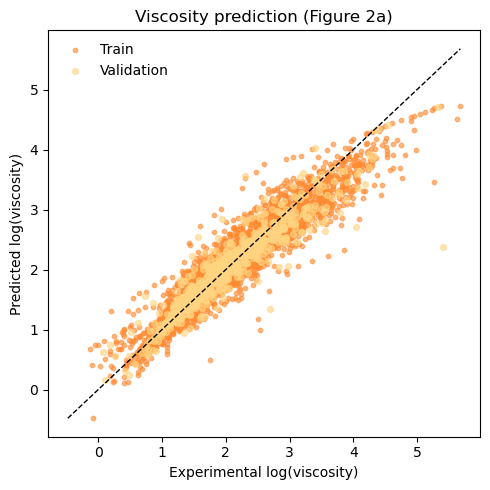

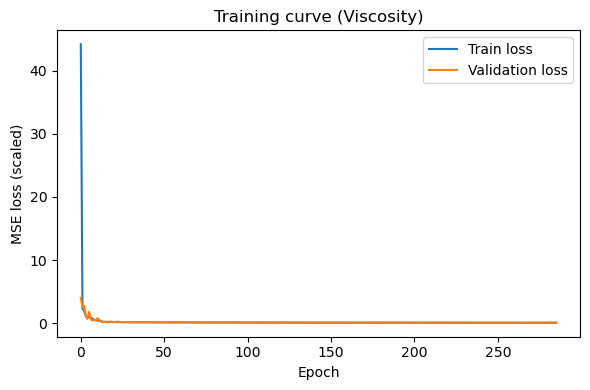

In [1]:
# ============================================================
# Notebook: Viscosity results visualization (Figure 2a)
# 打印 R² / MAE + Figure 2(a) + Loss 曲线
# ============================================================

# ---------- 环境 & 导入 ----------
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split

# 自定义层
from models.layers import (
    BondMatrixMessage, 
    GatedUpdate, 
    GlobalSumPool,
    Reduce, 
    AddTwoTensors, 
    SliceParamA, 
    SliceParamB, 
    SliceParamC,
    ScaleTemperature,
    ComputeLogEta
)

# 复用训练脚本中的工具函数（保持一致性）
from train_viscosity import (
    r2_numpy,
    pad_sequences_1d,
    preprocess_edges_and_bonds,
    plot_loss
)


# ============================================================
# 1. 加载数据
# ============================================================

with open("data/viscosity_id_data.pkl", "rb") as f:
    data = pickle.load(f)

y_all = np.array([d["log_eta"] for d in data], np.float32)

cat_atoms = [[a + 1 for a in d["cation"]["atom_ids"]] for d in data]
cat_bonds = [[b + 1 for b in d["cation"]["bond_ids"]] for d in data]
cat_edges = [d["cation"]["edge_indices"] for d in data]

an_atoms  = [[a + 1 for a in d["anion"]["atom_ids"]] for d in data]
an_bonds  = [[b + 1 for b in d["anion"]["bond_ids"]] for d in data]
an_edges  = [d["anion"]["edge_indices"] for d in data]

T = np.array([d["T"] for d in data], np.float32)[:, None]


# ============================================================
# 2. 数据划分（与 train_viscosity.py 完全一致）
# ============================================================

indices = np.arange(len(data))
idx_train, idx_tmp = train_test_split(indices, test_size=0.20, random_state=42)
idx_dev, idx_test  = train_test_split(idx_tmp, test_size=0.50, random_state=42)

y_train = y_all[idx_train]
y_dev   = y_all[idx_dev]
y_test  = y_all[idx_test]


# ============================================================
# 3. Padding 长度
# ============================================================

max_atoms = max(max(map(len, cat_atoms)), max(map(len, an_atoms)))
max_edges = max(max(map(len, cat_edges)), max(map(len, an_edges)))


# ============================================================
# 4. 构建模型输入
# ============================================================

def build_inputs(idxs):
    ce, cb = preprocess_edges_and_bonds(
        [cat_edges[i] for i in idxs],
        [cat_bonds[i] for i in idxs],
        max_edges
    )
    ae, ab = preprocess_edges_and_bonds(
        [an_edges[i] for i in idxs],
        [an_bonds[i] for i in idxs],
        max_edges
    )
    return {
        "cat_atom": pad_sequences_1d([cat_atoms[i] for i in idxs], max_atoms),
        "cat_bond": cb,
        "cat_connectivity": ce,
        "an_atom": pad_sequences_1d([an_atoms[i] for i in idxs], max_atoms),
        "an_bond": ab,
        "an_connectivity": ae,
        "temperature": T[idxs],
    }

x_train = build_inputs(idx_train)
x_dev   = build_inputs(idx_dev)
x_test  = build_inputs(idx_test)


# ============================================================
# 5. 加载模型
# ============================================================

model = keras.models.load_model(
    "models/viscosity_final.keras",
    custom_objects={
        "BondMatrixMessage": BondMatrixMessage,
        "GatedUpdate": GatedUpdate,
        "GlobalSumPool": GlobalSumPool,
        "Reduce": Reduce,
        "AddTwoTensors": AddTwoTensors,
        "SliceParamA": SliceParamA,
        "SliceParamB": SliceParamB,
        "SliceParamC": SliceParamC,
        "ScaleTemperature": ScaleTemperature,
        "ComputeLogEta": ComputeLogEta,
    }
)



# ============================================================
# 6. 打印 Train / Dev / Test 的 R² 和 MAE
# ============================================================

print("===== Viscosity prediction performance =====")

for name, x_, y_ in [
    ("Train", x_train, y_train),
    ("Dev",   x_dev,   y_dev),
    ("Test",  x_test,  y_test)
]:
    pred = model.predict(x_).flatten()
    print(
        f"{name}: "
        f"R2 = {r2_numpy(y_, pred):.4f}, "
        f"MAE = {np.mean(np.abs(y_ - pred)):.4f}"
    )


# ============================================================
# 7. 绘制 Figure 2(a)：训练 + 验证
# ============================================================

y_train_pred = model.predict(x_train).flatten()
y_dev_pred   = model.predict(x_dev).flatten()

plt.figure(figsize=(5, 5))

# Train：深橘
plt.scatter(
    y_train,
    y_train_pred,
    s=10,
    alpha=0.6,
    color="#FF8B32",
    label="Train"
)

# Dev：浅橘
plt.scatter(
    y_dev,
    y_dev_pred,
    s=18,
    alpha=0.6,
    color="#FFD582BE",
    label="Validation"
)

low = min(y_train.min(), y_dev.min(), y_train_pred.min(), y_dev_pred.min())
high = max(y_train.max(), y_dev.max(), y_train_pred.max(), y_dev_pred.max())
plt.plot([low, high], [low, high], "k--", linewidth=1)

plt.xlabel("Experimental log(viscosity)")
plt.ylabel("Predicted log(viscosity)")
plt.title("Viscosity prediction (Figure 2a)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


# ============================================================
# 8. 绘制损失曲线（来自 history.pkl）
# ============================================================

with open("results/history_viscosity.pkl", "rb") as f:
    history_dict = pickle.load(f)

class DummyHistory:
    def __init__(self, history):
        self.history = history

dummy_history = DummyHistory(history_dict)

plt.figure(figsize=(6, 4))
plt.plot(dummy_history.history["loss"], label="Train loss")
plt.plot(dummy_history.history["val_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("MSE loss (scaled)")
plt.title("Training curve (Viscosity)")
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
# ============================================================
# Melting Point Notebook Cell
# 只做：加载模型 + 评估 + 可视化（不训练）
# ============================================================

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import matplotlib.pyplot as plt
import pickle
import keras
from sklearn.model_selection import train_test_split
from models.layers import BondMatrixMessage, GatedUpdate, GlobalSumPool, Reduce
from train_melting_point import r2_numpy, pad_sequences_1d, preprocess_edges_and_bonds

# ============================================================
# 1. 加载数据 & vocab
# ============================================================

with open("data/mp_id_data.pkl", "rb") as f:
    data = pickle.load(f)

with open("data/vocab.pkl", "rb") as f:
    vocab = pickle.load(f)

atom_vocab_size = vocab["atom_vocab_size"] + 1
bond_vocab_size = vocab["bond_vocab_size"] + 1

# 提取特征（与训练脚本完全一致）
cat_atoms = [[a + 1 for a in d["cation"]["atom_ids"]] for d in data]
cat_bonds = [[b + 1 for b in d["cation"]["bond_ids"]] for d in data]
cat_edges = [d["cation"]["edge_indices"] for d in data]

an_atoms  = [[a + 1 for a in d["anion"]["atom_ids"]] for d in data]
an_bonds  = [[b + 1 for b in d["anion"]["bond_ids"]] for d in data]
an_edges  = [d["anion"]["edge_indices"] for d in data]

Y_all = np.array([d["mp"] for d in data], np.float32)

# ============================================================
# 2. 重建 Train / Dev / Test（必须与训练一致）
# ============================================================

indices = np.arange(len(data))
idx_train, idx_tmp = train_test_split(indices, test_size=0.20, random_state=42)
idx_dev, idx_test  = train_test_split(idx_tmp, test_size=0.50, random_state=42)

# 训练集统计量（用于反标准化）
Y_mean = Y_all[idx_train].mean()
Y_std  = Y_all[idx_train].std() or 1.0

max_atoms = max(max(map(len, cat_atoms)), max(map(len, an_atoms)))
max_edges = max(max(map(len, cat_edges)), max(map(len, an_edges)))

def build_inputs(idxs):
    ce, cb = preprocess_edges_and_bonds(
        [cat_edges[i] for i in idxs],
        [cat_bonds[i] for i in idxs],
        max_edges
    )
    ae, ab = preprocess_edges_and_bonds(
        [an_edges[i] for i in idxs],
        [an_bonds[i] for i in idxs],
        max_edges
    )
    return {
        "cat_atom": pad_sequences_1d([cat_atoms[i] for i in idxs], max_atoms),
        "cat_bond": cb,
        "cat_connectivity": ce,
        "an_atom": pad_sequences_1d([an_atoms[i] for i in idxs], max_atoms),
        "an_bond": ab,
        "an_connectivity": ae,
    }

x_train = build_inputs(idx_train)
x_dev   = build_inputs(idx_dev)
x_test  = build_inputs(idx_test)

# ============================================================
# 3. 加载模型
# ============================================================

model = keras.models.load_model(
    "models/melting_point_final.keras",
    custom_objects={
        "BondMatrixMessage": BondMatrixMessage,
        "GatedUpdate": GatedUpdate,
        "GlobalSumPool": GlobalSumPool,
        "Reduce": Reduce,
    }
)


# ============================================================
# 4. 打印 R² & MAE（原始尺度）
# ============================================================

print("\n--- Melting Point Evaluation (original scale) ---")
for name, x_, y_true in [
    ("Train", x_train, Y_all[idx_train]),
    ("Dev",   x_dev,   Y_all[idx_dev]),
    ("Test",  x_test,  Y_all[idx_test]),
]:
    pred = model.predict(x_).flatten() * Y_std + Y_mean
    print(
        f"{name}: R2={r2_numpy(y_true, pred):.4f}, "
        f"MAE={np.mean(np.abs(y_true - pred)):.4f}"
    )

# ============================================================
# 5. Loss 曲线（Notebook 展示版，不用 plot_loss）
# ============================================================

with open("results/loss_melting_point.pkl", "rb") as f:
    history = pickle.load(f)

plt.figure(figsize=(6, 4))
plt.plot(history["loss"], label="Train loss")
plt.plot(history["val_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("MSE loss (scaled)")
plt.title("Training curve (Melting Point)")
plt.legend()
plt.tight_layout()
plt.show()


TypeError: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': {'module': 'keras.optimizers.schedules', 'class_name': 'InverseTimeDecay', 'config': {'initial_learning_rate': 0.01, 'decay_steps': 4837.5, 'decay_rate': 0.44999999999999996, 'staircase': False, 'name': 'InverseTimeDecay'}, 'registered_name': None}, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': 'mean_squared_error', 'loss_weights': None, 'metrics': [{'module': 'keras.metrics', 'class_name': 'R2Score', 'config': {'name': 'r2_score', 'dtype': 'float32', 'class_aggregation': 'uniform_average', 'num_regressors': 0}, 'registered_name': None}], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': True}}.

Exception encountered: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': {}, 'name': 'MPNN_Base', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, None], 'dtype': 'int32', 'keras_history': ['cat_atom_ids', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, None], 'dtype': 'int32', 'keras_history': ['cat_bond_ids', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, None, 2], 'dtype': 'int32', 'keras_history': ['cat_edge_indices', 0, 0]}}]], 'kwargs': {'mask': [None, None, None]}}, {'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, None], 'dtype': 'int32', 'keras_history': ['an_atom_ids', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, None], 'dtype': 'int32', 'keras_history': ['an_bond_ids', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, None, 2], 'dtype': 'int32', 'keras_history': ['an_edge_indices', 0, 0]}}]], 'kwargs': {'mask': [None, None, None]}}]}.

Exception encountered: <class 'keras.src.layers.core.lambda_layer.Lambda'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.layers', 'class_name': 'Lambda', 'config': {'name': 'Msg_step_0', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 126447991093424}, 'function': {'module': 'builtins', 'class_name': 'function', 'config': 'compute_msg_vectors', 'registered_name': 'function'}, 'arguments': {}}, 'registered_name': None, 'build_config': {'input_shape': [[None, None, 1024], [None, None, 32]]}, 'name': 'Msg_step_0', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, None, 1024], 'dtype': 'float32', 'keras_history': ['bond_embedding', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, None, 32], 'dtype': 'float32', 'keras_history': ['Gather_step_0', 0, 0]}}]], 'kwargs': {}}]}.

Exception encountered: Could not locate function 'compute_msg_vectors'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'compute_msg_vectors', 'registered_name': 'function'}